In [12]:
%matplotlib widget

# Use: pip install ipywidgets ipympl
  
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add project path
project_root = Path("..").resolve()
sys.path.append(str(project_root))

from ml_toolbox.data_loader import DataLoader, WindowConfig, WindowExtractor

In [13]:
# Load data and create windows
dataset_path = Path("../data_set")
data_loader = DataLoader(dataset_path)

# Load one sample for demo
current_data, metadata = data_loader.load_batch(
    condition='healthy', 
    load='no_load', 
    sensor_type='current', 
    apply_filter=False,
    max_workers=1
)


num_samples = current_data[0].shape[0] 
# Create windows
window_size = num_samples # All file
overlap_ratio = 0.5
step_size = int(window_size * (1 - overlap_ratio))
window_config = WindowConfig(window_size=window_size, 
                             step_size=step_size,
                             overlap_ratio=overlap_ratio)
extractor = WindowExtractor(window_config)
windows, win_metadata = extractor.extract_windows(current_data[0], metadata[0])
    
    
print(f"Loaded signal: {current_data[0].shape}")
print(f"Created {len(windows)} windows")


INFO:ml_toolbox.data_loader.data_loader:Loading 11 files with 1 workers


INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 11 files


Loaded signal: (113400, 2)
Created 1 windows


In [15]:
import scipy.signal as signal_proc
from scipy.signal import butter, filtfilt, medfilt
import pandas as pd

def hampel_filter(data, window_size=31, n_sigma=3):
    """
    Apply Hampel filter to remove outliers/spikes
    
    Parameters:
    - data: input signal
    - window_size: size of the moving window (should be odd)
    - n_sigma: number of standard deviations for outlier detection
    """
    # Ensure window_size is odd
    if window_size % 2 == 0:
        window_size += 1
    
    half_window = window_size // 2
    filtered_data = data.copy()
    
    # Convert to pandas Series for rolling operations
    series = pd.Series(data)
    
    # Calculate rolling median and MAD (Median Absolute Deviation)
    rolling_median = series.rolling(window=window_size, center=True).median()
    rolling_mad = series.rolling(window=window_size, center=True).apply(
        lambda x: np.median(np.abs(x - np.median(x)))
    )
    
    # Identify outliers
    threshold = n_sigma * 1.4826 * rolling_mad  # 1.4826 is conversion factor for MAD to std
    outliers = np.abs(series - rolling_median) > threshold
    
    # Replace outliers with median values
    filtered_data[outliers] = rolling_median[outliers]
    
    # Handle NaN values at edges
    filtered_data = pd.Series(filtered_data).fillna(method='bfill').fillna(method='ffill').values
    
    return filtered_data, outliers.values

def design_butterworth_filter(cutoff_freq, sampling_freq, order=4):
    """
    Design Butterworth lowpass filter
    
    Parameters:
    - cutoff_freq: cutoff frequency in Hz
    - sampling_freq: sampling frequency in Hz
    - order: filter order
    """
    nyquist = sampling_freq / 2
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_zero_phase_filter(data, b, a):
    """
    Apply zero-phase filtering using filtfilt
    """
    return filtfilt(b, a, data)

# Signal processing parameters
sampling_freq = 10000  # 10 kHz
cutoff_freq = 3500     # 3.5 kHz cutoff
hampel_window = 31     # Hampel filter window
median_window = 7      # Alternative median filter window

print(f"Signal processing parameters:")
print(f"- Sampling frequency: {sampling_freq} Hz")
print(f"- Cutoff frequency: {cutoff_freq} Hz")
print(f"- Hampel filter window: {hampel_window} samples")
print(f"- Median filter window: {median_window} samples")

Signal processing parameters:
- Sampling frequency: 10000 Hz
- Cutoff frequency: 3500 Hz
- Hampel filter window: 31 samples
- Median filter window: 7 samples


In [16]:
# Process the signal - apply despiking and filtering
window = windows[0]
original_signal = window[:, 0] if window.shape[1] > 0 else window

print(f"Original signal shape: {original_signal.shape}")
print(f"Signal range: [{original_signal.min():.4f}, {original_signal.max():.4f}]")

# Step 1: Despike using Hampel filter
despiked_signal, outliers = hampel_filter(original_signal, window_size=hampel_window, n_sigma=3)
print(f"Hampel filter removed {np.sum(outliers)} outliers ({100*np.sum(outliers)/len(outliers):.2f}%)")

# Alternative: Median filter for comparison
median_filtered = medfilt(original_signal, kernel_size=median_window)

# Step 2: Design and apply Butterworth lowpass filter
b, a = design_butterworth_filter(cutoff_freq, sampling_freq, order=4)
filtered_signal = apply_zero_phase_filter(despiked_signal, b, a)

# Also filter the median-filtered version for comparison
filtered_median = apply_zero_phase_filter(median_filtered, b, a)

# Create time vector
time = np.arange(len(original_signal)) / sampling_freq

print(f"Processing complete!")
print(f"Filtered signal range: [{filtered_signal.min():.4f}, {filtered_signal.max():.4f}]")

Original signal shape: (113400,)
Signal range: [-0.8612, 0.8092]
Hampel filter removed 54818 outliers (48.34%)
Processing complete!
Filtered signal range: [-0.4974, 0.4954]


C:\Users\jkcvk\AppData\Local\Temp\ipykernel_16188\2056066970.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = pd.Series(filtered_data).fillna(method='bfill').fillna(method='ffill').values


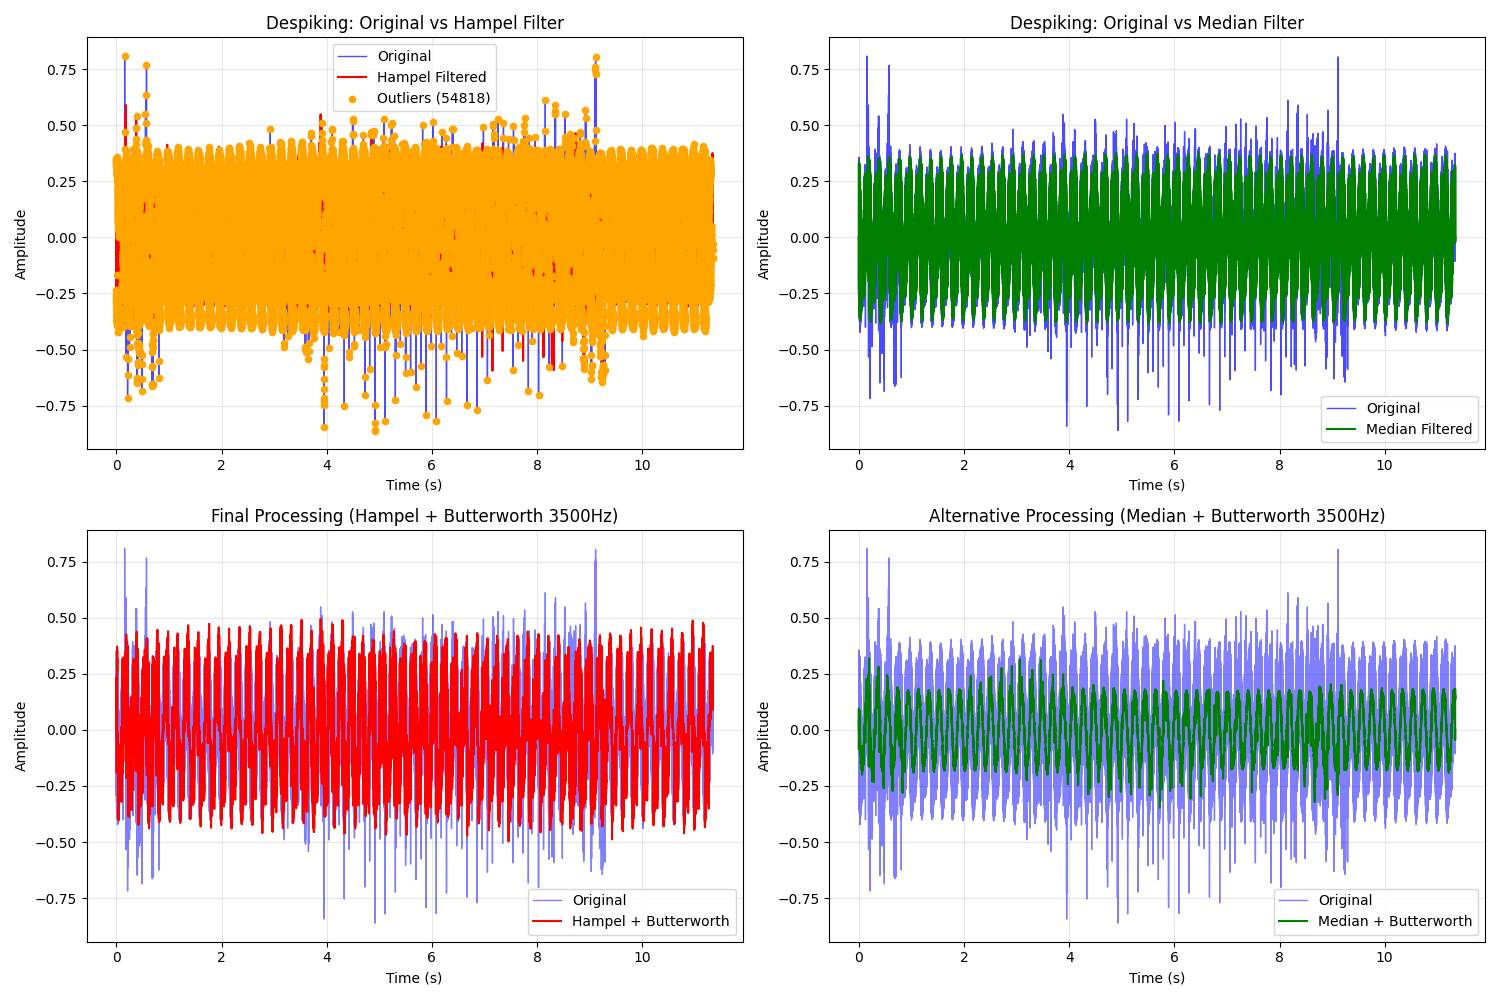

In [17]:
# Interactive plot - compare original and processed signals
plt.ioff()  # Turn off interactive mode temporarily
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Original vs Hampel despiked
axes[0, 0].plot(time, original_signal, 'b-', linewidth=1, alpha=0.7, label='Original')
axes[0, 0].plot(time, despiked_signal, 'r-', linewidth=1.5, label='Hampel Filtered')
if np.sum(outliers) > 0:
    axes[0, 0].scatter(time[outliers], original_signal[outliers], 
                      c='orange', s=20, label=f'Outliers ({np.sum(outliers)})', zorder=5)
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_title('Despiking: Original vs Hampel Filter')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot 2: Original vs Median filtered
axes[0, 1].plot(time, original_signal, 'b-', linewidth=1, alpha=0.7, label='Original')
axes[0, 1].plot(time, median_filtered, 'g-', linewidth=1.5, label='Median Filtered')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title('Despiking: Original vs Median Filter')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot 3: Final processed signal (Hampel + Butterworth)
axes[1, 0].plot(time, original_signal, 'b-', linewidth=1, alpha=0.5, label='Original')
axes[1, 0].plot(time, filtered_signal, 'r-', linewidth=1.5, label='Hampel + Butterworth')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].set_title(f'Final Processing (Hampel + Butterworth {cutoff_freq}Hz)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Plot 4: Alternative processing (Median + Butterworth)
axes[1, 1].plot(time, original_signal, 'b-', linewidth=1, alpha=0.5, label='Original')
axes[1, 1].plot(time, filtered_median, 'g-', linewidth=1.5, label='Median + Butterworth')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_ylabel('Amplitude')
axes[1, 1].set_title(f'Alternative Processing (Median + Butterworth {cutoff_freq}Hz)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.ion()  # Turn interactive mode back on
plt.show()

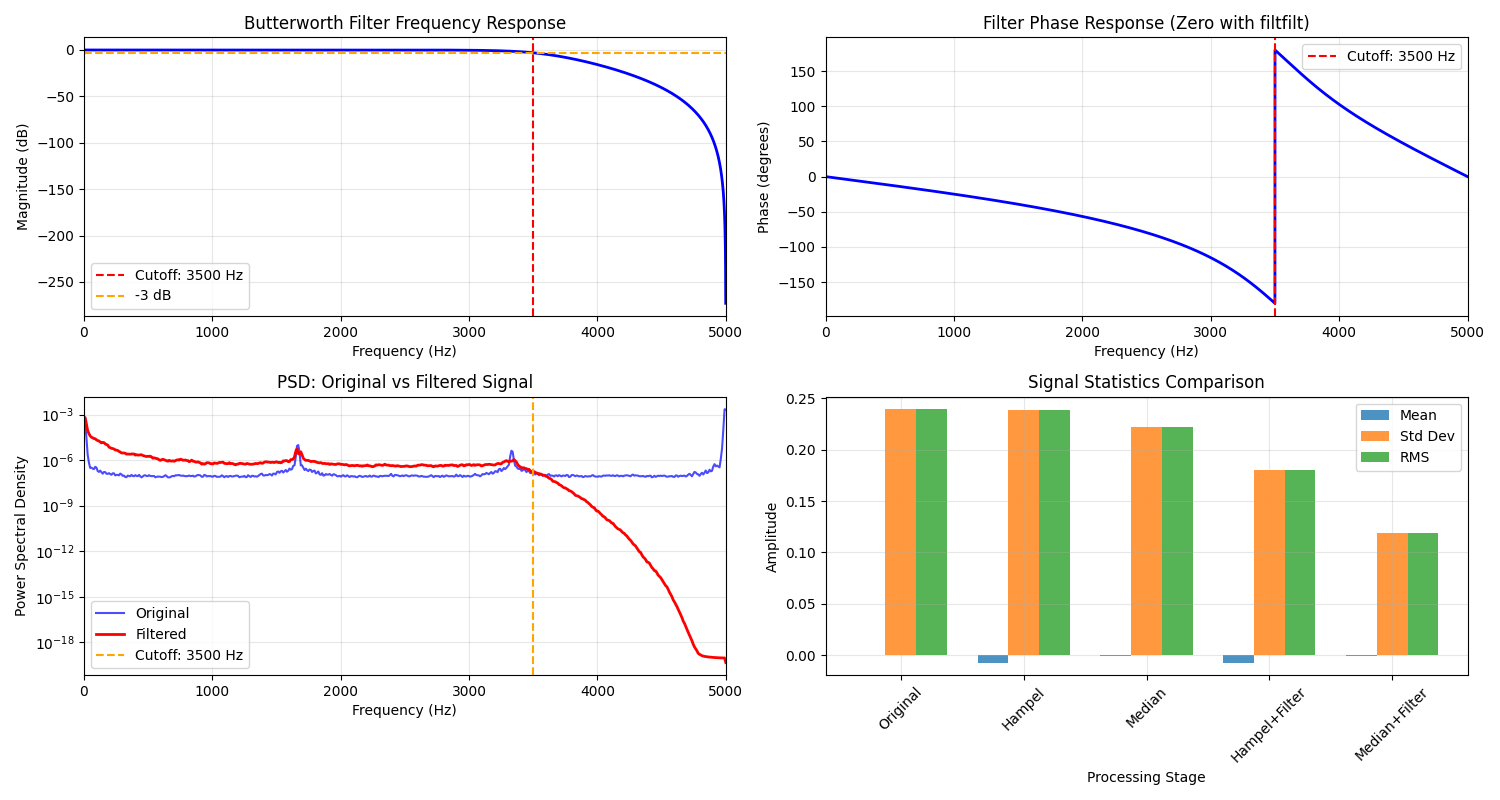


Signal Processing Summary:
Original signal: μ=-0.0000, σ=0.2392
Hampel filtered: μ=-0.0069, σ=0.2380
Final processed: μ=-0.0069, σ=0.1805
Noise reduction: 24.6%


In [18]:
# Analyze filter characteristics and signal statistics
from scipy.signal import freqz

# Get filter frequency response
w, h = freqz(b, a, worN=8000, fs=sampling_freq)

# Calculate power spectral density for original and filtered signals
freqs_orig, psd_orig = signal_proc.welch(original_signal, fs=sampling_freq, nperseg=1024)
freqs_filt, psd_filtered = signal_proc.welch(filtered_signal, fs=sampling_freq, nperseg=1024)

plt.ioff()
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Plot 1: Filter frequency response
axes[0, 0].plot(w, 20 * np.log10(abs(h)), 'b-', linewidth=2)
axes[0, 0].axvline(cutoff_freq, color='r', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
axes[0, 0].axhline(-3, color='orange', linestyle='--', label='-3 dB')
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('Magnitude (dB)')
axes[0, 0].set_title('Butterworth Filter Frequency Response')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 5000)

# Plot 2: Phase response
axes[0, 1].plot(w, np.angle(h) * 180 / np.pi, 'b-', linewidth=2)
axes[0, 1].axvline(cutoff_freq, color='r', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Phase (degrees)')
axes[0, 1].set_title('Filter Phase Response (Zero with filtfilt)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 5000)

# Plot 3: Power spectral density comparison
axes[1, 0].semilogy(freqs_orig, psd_orig, 'b-', alpha=0.7, label='Original')
axes[1, 0].semilogy(freqs_filt, psd_filtered, 'r-', linewidth=2, label='Filtered')
axes[1, 0].axvline(cutoff_freq, color='orange', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Power Spectral Density')
axes[1, 0].set_title('PSD: Original vs Filtered Signal')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_xlim(0, 5000)

# Plot 4: Signal statistics
stats_data = {
    'Signal': ['Original', 'Hampel', 'Median', 'Hampel+Filter', 'Median+Filter'],
    'Mean': [np.mean(original_signal), np.mean(despiked_signal), np.mean(median_filtered), 
             np.mean(filtered_signal), np.mean(filtered_median)],
    'Std': [np.std(original_signal), np.std(despiked_signal), np.std(median_filtered), 
            np.std(filtered_signal), np.std(filtered_median)],
    'RMS': [np.sqrt(np.mean(original_signal**2)), np.sqrt(np.mean(despiked_signal**2)), 
            np.sqrt(np.mean(median_filtered**2)), np.sqrt(np.mean(filtered_signal**2)), 
            np.sqrt(np.mean(filtered_median**2))]
}

# Create bar plot of statistics
x_pos = np.arange(len(stats_data['Signal']))
width = 0.25
axes[1, 1].bar(x_pos - width, stats_data['Mean'], width, label='Mean', alpha=0.8)
axes[1, 1].bar(x_pos, stats_data['Std'], width, label='Std Dev', alpha=0.8)
axes[1, 1].bar(x_pos + width, stats_data['RMS'], width, label='RMS', alpha=0.8)
axes[1, 1].set_xlabel('Processing Stage')
axes[1, 1].set_ylabel('Amplitude')
axes[1, 1].set_title('Signal Statistics Comparison')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(stats_data['Signal'], rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.ion()
plt.show()

# Print summary statistics
print("\nSignal Processing Summary:")
print("="*50)
print(f"Original signal: μ={np.mean(original_signal):.4f}, σ={np.std(original_signal):.4f}")
print(f"Hampel filtered: μ={np.mean(despiked_signal):.4f}, σ={np.std(despiked_signal):.4f}")
print(f"Final processed: μ={np.mean(filtered_signal):.4f}, σ={np.std(filtered_signal):.4f}")
print(f"Noise reduction: {((np.std(original_signal) - np.std(filtered_signal))/np.std(original_signal)*100):.1f}%")

In [22]:
# Generate comprehensive PDF report for all datasets
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

def process_and_plot_all_datasets():
    """
    Process all datasets and create PDF with 4 plots per page:
    - Top left: Channel A unfiltered
    - Top right: Channel B unfiltered  
    - Bottom left: Channel A filtered
    - Bottom right: Channel B filtered
    """
    
    # All conditions and loads to process
    conditions = ['healthy', 'faulty bearing', 'misalignment', 'system misalignment']
    loads = ['no_load', 'under_load']
    
    # Use configuration from cell 2
    dataset_path = Path("../data_set")
    data_loader = DataLoader(dataset_path)
    
    # PDF output file
    pdf_filename = "../all_datasets_analysis.pdf"
    
    with PdfPages(pdf_filename) as pdf:
        page_count = 0
        
        for condition in conditions:
            for load in loads:
                try:
                    print(f"Processing: {condition} - {load}")
                    
                    # Load current data
                    current_data, metadata = data_loader.load_batch(
                        condition=condition,
                        load=load,
                        sensor_type='current',
                        max_workers=1
                    )
                    
                    if not current_data:
                        print(f"No data found for {condition} - {load}")
                        continue
                    
                    # Use first file from the batch
                    signal_data = current_data[0]
                    signal_metadata = metadata[0]
                    
                    # Create windows using same config as cell 2
                    num_samples = signal_data.shape[0]
                    window_size = num_samples  # All file
                    overlap_ratio = 0.5
                    step_size = int(window_size * (1 - overlap_ratio))
                    window_config = WindowConfig(window_size=window_size, 
                                               step_size=step_size,
                                               overlap_ratio=overlap_ratio)
                    extractor = WindowExtractor(window_config)
                    windows, win_metadata = extractor.extract_windows(signal_data, signal_metadata)
                    
                    # Process first window
                    window = windows[0]
                    
                    # Extract channels A and B
                    if window.shape[1] >= 2:
                        channel_a = window[:, 0]
                        channel_b = window[:, 1]
                    else:
                        # If only one channel, duplicate it
                        channel_a = window[:, 0] if window.shape[1] > 0 else window.flatten()
                        channel_b = channel_a.copy()
                    
                    # Apply filtering to both channels using median filter instead of Hampel
                    # Channel A processing
                    median_filtered_a = medfilt(channel_a, kernel_size=median_window)
                    filtered_a = apply_zero_phase_filter(median_filtered_a, b, a)
                    
                    # Channel B processing  
                    median_filtered_b = medfilt(channel_b, kernel_size=median_window)
                    filtered_b = apply_zero_phase_filter(median_filtered_b, b, a)
                    
                    # Create time vector
                    time = np.arange(len(channel_a)) / sampling_freq
                    
                    # Create the 4-subplot figure
                    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
                    
                    # Plot 1: Channel A unfiltered
                    axes[0, 0].plot(time, channel_a, 'b-', linewidth=1, alpha=0.8)
                    axes[0, 0].set_title(f'Channel A - Unfiltered\n{condition.title()} - {load.replace("_", " ").title()}', 
                                        fontsize=12, fontweight='bold')
                    axes[0, 0].set_xlabel('Time (s)')
                    axes[0, 0].set_ylabel('Amplitude')
                    axes[0, 0].grid(True, alpha=0.3)
                    
                    # Plot 2: Channel B unfiltered
                    axes[0, 1].plot(time, channel_b, 'g-', linewidth=1, alpha=0.8)
                    axes[0, 1].set_title(f'Channel B - Unfiltered\n{condition.title()} - {load.replace("_", " ").title()}', 
                                        fontsize=12, fontweight='bold')
                    axes[0, 1].set_xlabel('Time (s)')
                    axes[0, 1].set_ylabel('Amplitude')
                    axes[0, 1].grid(True, alpha=0.3)
                    
                    # Plot 3: Channel A filtered (only filtered signal)
                    axes[1, 0].plot(time, filtered_a, 'r-', linewidth=1.5)
                    axes[1, 0].set_title(f'Channel A - Filtered (Median + Butterworth {cutoff_freq}Hz)', 
                                        fontsize=12, fontweight='bold')
                    axes[1, 0].set_xlabel('Time (s)')
                    axes[1, 0].set_ylabel('Amplitude')
                    axes[1, 0].grid(True, alpha=0.3)
                    
                    # Plot 4: Channel B filtered (only filtered signal)
                    axes[1, 1].plot(time, filtered_b, 'purple', linewidth=1.5)
                    axes[1, 1].set_title(f'Channel B - Filtered (Median + Butterworth {cutoff_freq}Hz)', 
                                        fontsize=12, fontweight='bold')
                    axes[1, 1].set_xlabel('Time (s)')
                    axes[1, 1].set_ylabel('Amplitude')
                    axes[1, 1].grid(True, alpha=0.3)
                    
                    # Add overall figure title
                    fig.suptitle(f'Dataset Analysis: {condition.title()} - {load.replace("_", " ").title()}\n'
                               f'File: {signal_metadata.get("filename", "Unknown")} | '
                               f'Sampling: {sampling_freq}Hz | Median kernel: {median_window}', 
                               fontsize=14, fontweight='bold', y=0.95)
                    
                    plt.tight_layout()
                    plt.subplots_adjust(top=0.88)  # Make room for suptitle
                    
                    # Save to PDF
                    pdf.savefig(fig, dpi=150, bbox_inches='tight')
                    plt.close(fig)  # Free memory
                    
                    page_count += 1
                    print(f"✓ Page {page_count} added: {condition} - {load}")
                    
                except Exception as e:
                    print(f"✗ Error processing {condition} - {load}: {str(e)}")
                    continue
    
    print(f"\n📄 PDF report generated: {pdf_filename}")
    print(f"📊 Total pages: {page_count}")
    return pdf_filename

# Execute the analysis
pdf_file = process_and_plot_all_datasets()

INFO:ml_toolbox.data_loader.data_loader:Loading 11 files with 1 workers


INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 11 files


Processing: healthy - no_load


INFO:ml_toolbox.data_loader.data_loader:Loading 12 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Loading 12 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 12 files
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 12 files


✓ Page 1 added: healthy - no_load
Processing: healthy - under_load
No data found for healthy - under_load
Processing: faulty bearing - no_load


INFO:ml_toolbox.data_loader.data_loader:Loading 4 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 4 files
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 4 files


✓ Page 2 added: faulty bearing - no_load
Processing: faulty bearing - under_load


INFO:ml_toolbox.data_loader.data_loader:Loading 12 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 12 files
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 12 files


✓ Page 3 added: faulty bearing - under_load
Processing: misalignment - no_load


INFO:ml_toolbox.data_loader.data_loader:Loading 12 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 12 files
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 12 files


✓ Page 4 added: misalignment - no_load
Processing: misalignment - under_load


INFO:ml_toolbox.data_loader.data_loader:Loading 12 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 12 files
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 12 files


✓ Page 5 added: misalignment - under_load
Processing: system misalignment - no_load


INFO:ml_toolbox.data_loader.data_loader:Loading 4 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 4 files
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 4 files


✓ Page 6 added: system misalignment - no_load
Processing: system misalignment - under_load
✓ Page 7 added: system misalignment - under_load

📄 PDF report generated: ../all_datasets_analysis.pdf
📊 Total pages: 7
✓ Page 7 added: system misalignment - under_load

📄 PDF report generated: ../all_datasets_analysis.pdf
📊 Total pages: 7
